# Image classification

## Build the dataset

In the previous section, we saw how to decompose an image into its HOG descriptors. This allows us to reduce the number of features that will be use to perform the classification.

Those HOG descriptors can now be used as any normal set of attributes, just the same way we did in the previous chapter with AIS data. We only need to create a dataset, with one entry for each image, one attribute for each HOG descriptor, and a class attribute. As an example, a dataset for animal classification could look like that:

![text](2-1-3-image-dataset.jpg)

For this to work fine, we need each image to have the same number of HOG descriptor. We saw in the previous section that the number of HOG descriptors depends on two parameters:
- the parameters chosen in the HOG function: we decide on the number of pixels to group together for the HOG descriptors. The more pixels are in the same group, the less HOG descriptors we get.
- the size of the image: similarly as for the parameters of the function, the bigger the image, the more HOG descriptors we get.

In our case, it is therefore important for each image to have the same size (same number of pixels) and the same parameters for the HOG descriptors.

With that in mind, we can now build our dataset by importing the images with their class and calculating the HOG descriptors for each of them. We are in possession of a .csv file ``2-images.csv`` containing the path and the class of each image. Then, we only need to loop over the images to calculate their HOG descriptor and put everything in a Pandas DataFrame.

First, we read the .csv file.

In [1]:
import pandas as pd

images = pd.read_csv('./2-images.csv')

images.head()

,image_path,label
0,./data/1.jpg,cat
1,./data/2.jpg,cat
2,./data/3.jpg,cat
3,./data/4.jpg,cat
4,./data/5.jpg,cat


Now, we can loop on each image path to read the image itself, calculate its HOG descriptors and put everything in a Dataframe for classification. We keep the read image in the DataFrame to be able to plot it later if needed.

In [4]:
from skimage import io
from skimage.feature import hog

hog_features = []
for file in images['image_path']:
    hog_features.append(feature.hog(io.imread(file), # the image read
                            orientations = 8,
                            pixels_per_cell = (40, 40),
                            visualize = False)
                       )

images = images.assign(hog_features = hog_features)

images.head()

,image_path,label,hog_features
0,./data/1.jpg,cat,"[0.10489434136776081, 0.03000765876042029, 0.1..."
1,./data/2.jpg,cat,"[0.06511460912671653, 0.036009570336997296, 0...."
2,./data/3.jpg,cat,"[0.0645168443208118, 0.012273334354864062, 0.0..."
3,./data/4.jpg,cat,"[0.15030760450655362, 0.04317479024740703, 0.0..."
4,./data/5.jpg,cat,"[0.04515955710031582, 0.023032858411843354, 0...."


In this example, all the HOG descriptors are stored as a list in a single attribute. This is not a problem for classification, we will unpack them when doing the classification to treat each of them as a single attribute.

## Perform the classification

Now that we have the dataset, we can do the classification exactly how we are doing it usually.

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

train, test, y_train, y_test = train_test_split(images[['image_path', 'hog_features']], # we keep the attribute 'image_path' to
                                                #be able to access the image to check the classification if needed
                                                images['label'],
                                                test_size = 0.2,
                                                random_state = 0)

x_train = np.stack(train['hog_features'].values)
x_test = np.stack(test['hog_features'].values)
    
random_forest = RandomForestClassifier(n_estimators = 10, max_depth = 7, random_state = 0)
random_forest.fit(x_train, y_train.values)
predictions = random_forest.predict(x_test)
    
accuracy = accuracy_score(predictions, y_test)

print('Accuracy: ' + str(accuracy))

Accuracy: 0.25


After performing the classification, we can have a better look at the results to see which images were correctly or wrongly classified by our model:

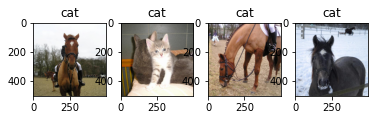

In [8]:
import matplotlib.pyplot as plt

i = 0
l = len(test)
for index, row in test.iterrows():
    plt.subplot(1, l, i+1)
    plt.imshow(io.imread(row['image_path']))
    plt.title(str(predictions[i]))
    i = i + 1
plt.show()

In that case, we can see that the classification is very bad. This is very likely due to the very small size of the dataset.

Indeed, the dataset contains 19 images, but each image contains 7200 HOG descriptors. The amount of images in the dataset is way too small.

## Create functions

To automatize the creation of the dataset, the classification of the images and the representation of the results, we can write a few functions that we can reuse with any other image dataset.

In [16]:
def create_hog(df):
    # Takes a DataFrame with the path of the image, returns the same DataFrame enriched with the hog descriptors
    
    from skimage import io
    from skimage.feature import hog

    hog_features = []
    for file in df['image_path']:
        hog_features.append(feature.hog(io.imread(file), # the image read
                                        orientations = 8,
                                        pixels_per_cell = (40, 40),
                                        visualize = False)
                           )

    df = df.assign(hog_features = hog_features)
    
    return df

In [19]:
def classify_images(df, random_state = 0):
    # From a df, performs image classification and returns the results
    # Takes random_state as an input to allow different reproducible results
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split

    train, test, y_train, y_test = train_test_split(df[['image_path', 'hog_features']], # we keep the attribute 'image_path' to
                                                    #be able to access the image to check the classification if needed
                                                    df['label'],
                                                    test_size = 0.2,
                                                    random_state = random_state)

    x_train = np.stack(train['hog_features'].values)
    x_test = np.stack(test['hog_features'].values)

    random_forest = RandomForestClassifier(n_estimators = 10, max_depth = 7, random_state = 0)
    random_forest.fit(x_train, y_train.values)
    predictions = random_forest.predict(x_test)
    
    return predictions, y_test, test

In [20]:
def print_results(predictions, test):
    
    import matplotlib.pyplot as plt

    i = 0
    l = len(test)
    for index, row in test.iterrows():
        plt.subplot(1, l, i+1)
        plt.imshow(io.imread(row['image_path']))
        plt.title(str(predictions[i]))
        i = i + 1
    plt.show()

Now, to perform the classification, we only have to run those functions as following:

Accuracy: 0.5


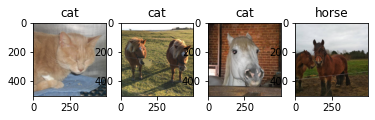

In [25]:
import pandas as pd
from sklearn.metrics import accuracy_score

images = pd.read_csv('./2-images.csv')
images = create_hog(images)
pred, y_test, test = classify_images(images, 1)
print('Accuracy: ' + str(accuracy_score(pred, y_test)))
print_results(pred, test)

We can try different values for ``random_state`` to see different results:

Accuracy: 0.75


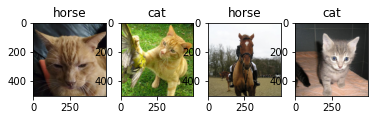

In [26]:
pred, y_test, test = classify_images(images, 2)
print('Accuracy: ' + str(accuracy_score(pred, y_test)))
print_results(pred, test)

Accuracy: 0.25


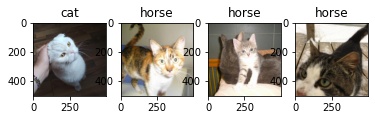

In [27]:
pred, y_test, test = classify_images(images, 3)
print('Accuracy: ' + str(accuracy_score(pred, y_test)))
print_results(pred, test)